In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

# Load Data 

In [4]:
path = r'C:\Users\rifky\Downloads\Rakamin Project-Based Virtual Internship\Home Credit Indonesia (Data Science)\Final Project\dataset'

X_train_upsampled_chi2 = pd.read_csv(os.path.join(path, 'X_train_upsampled_chi2.csv'))
y_train_upsampled_chi2 = pd.read_csv(os.path.join(path, 'y_train_upsampled_chi2.csv'))

X_train_upsampled_mi = pd.read_csv(os.path.join(path, 'X_train_upsampled_mi.csv'))
y_train_upsampled_mi = pd.read_csv(os.path.join(path, 'y_train_upsampled_mi.csv'))

X_val_chi2 = pd.read_csv(os.path.join(path, 'X_val_chi2.csv'))
X_val_mi = pd.read_csv(os.path.join(path, 'X_val_mi.csv'))
y_val = pd.read_csv(os.path.join(path, 'y_val.csv'))

X_test_chi2

# Model Building 

### >> Create a helper function

In [5]:
def latih_dan_evaluasi_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Fungsi untuk melatih, mengevaluasi, dan memvisualisasikan model machine learning.
    """
    print(f"Train and evaluate: {model_name}")
    
    start_time = time.time()
    model.fit(X_train, y_train)
    exec_time = time.time() - start_time
    print(f"Execution time: {exec_time:.5f}s")
    
    if hasattr(model, 'best_params_'):
        print(f"\nBest Parameters: {model.best_params_}")
        print(f"Best ROC-AUC (CV): {model.best_score_:.4f}")

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nROC-AUC on Test Set:")
    auc_score = roc_auc_score(y_test, y_proba)
    print(f"{auc_score:.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Visualisasi Kurva ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-AUC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
        
    return model

### Logistic Regression

Train and evaluate: Logistic Regression (Data Chi2)
Execution time: 0.96654s

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56536
           1       0.15      0.66      0.25      4965

    accuracy                           0.68     61501
   macro avg       0.56      0.67      0.52     61501
weighted avg       0.89      0.68      0.75     61501


ROC-AUC on Test Set:
0.7327

Confusion Matrix:


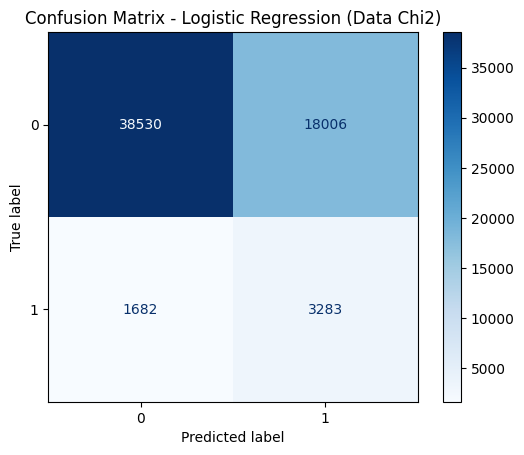

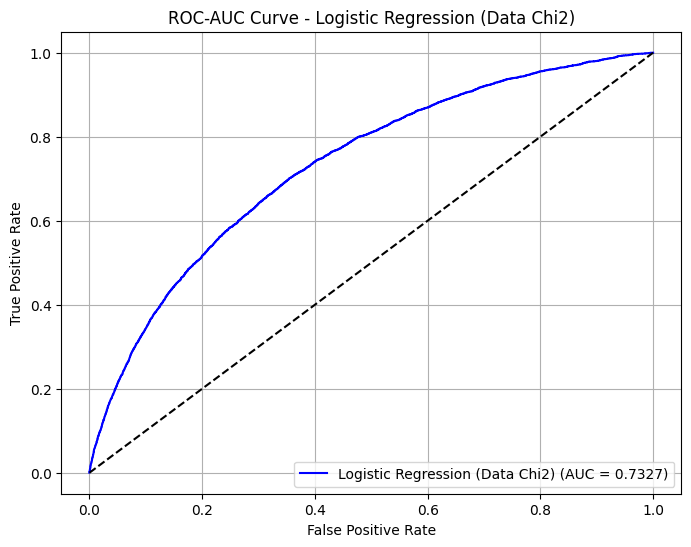

In [10]:
log_reg_model = LogisticRegression()
log_reg_model_fitted = latih_dan_evaluasi_model(log_reg_model, 
                                                X_train_upsampled_chi2, y_train_upsampled_chi2, 
                                                X_val_chi2, y_val, 
                                                model_name="Logistic Regression (Data Chi2)")

### LightGBM

In [34]:
X_train_upsampled_mi = np.array(X_train_upsampled_mi)
y_train_upsampled_mi = np.array(y_train_upsampled_mi)
X_val_mi = np.array(X_val_mi)
y_val = np.array(y_val)

Nilai scale_pos_weight yang disarankan: 11.386908358509567
Train and evaluate: LightGBM (Data MI)
[LightGBM] [Info] Number of positive: 226144, number of negative: 226144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1879
[LightGBM] [Info] Number of data points in the train set: 452288, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Execution time: 1.08973s

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.07      0.14     56536
           1       0.09      0.99      0.16      4965

    accuracy                           0.15     61501
   macro avg       0.54      0.53      0.15     61501
weighted avg       0.91      0.15      0.14     61501


ROC-AUC on Test Set

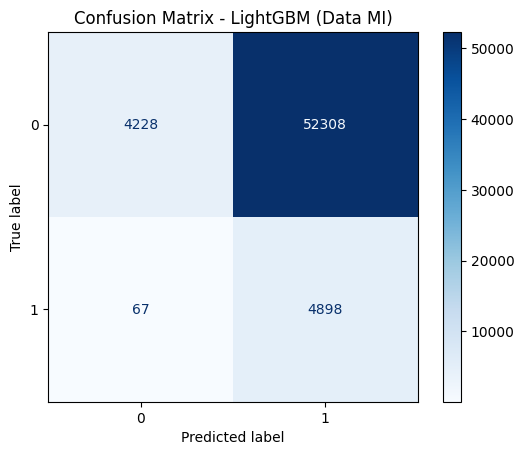

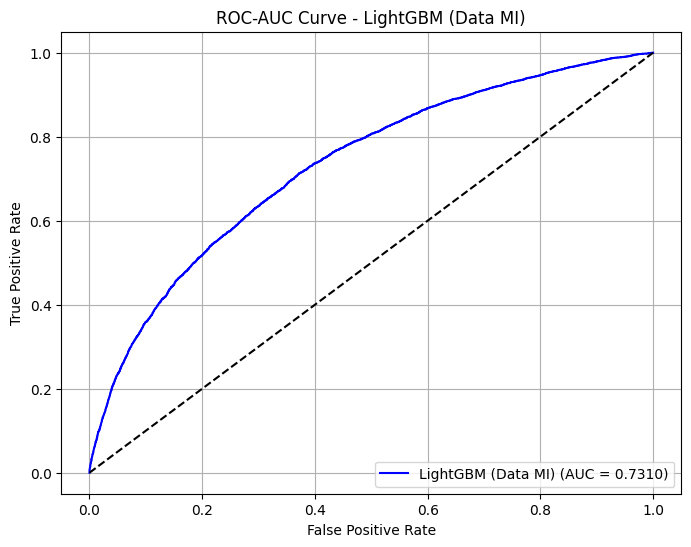

In [35]:
count_class_0 = (y_val == 0).sum()
count_class_1 = (y_val == 1).sum()
scale_pos_weight = count_class_0 / count_class_1
print(f"Nilai scale_pos_weight yang disarankan: {scale_pos_weight}")

lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1, verbose=1, scale_pos_weight=scale_pos_weight)
lgbm_model_fitted = latih_dan_evaluasi_model(lgbm_model, 
                                             X_train_upsampled_mi, y_train_upsampled_mi, 
                                             X_val_mi, y_val, 
                                             model_name="LightGBM (Data MI)")

### Random Forest

Train and evaluate: Random Forest (Data Chi2)
Execution time: 74.74489s

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       0.34      0.02      0.04      4965

    accuracy                           0.92     61501
   macro avg       0.63      0.51      0.50     61501
weighted avg       0.87      0.92      0.88     61501


ROC-AUC on Test Set:
0.7061

Confusion Matrix:


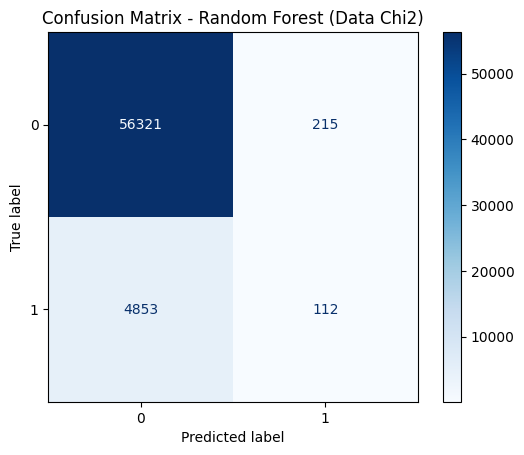

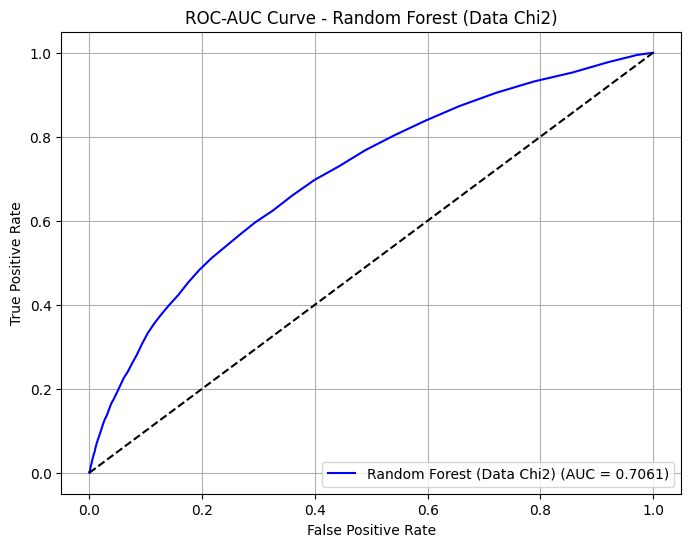

In [36]:
rfc_model = RandomForestClassifier()
rfc_model_fitted = latih_dan_evaluasi_model(rfc_model, 
                                            X_train_upsampled_chi2, y_train_upsampled_chi2, 
                                            X_val_chi2, y_val, 
                                            model_name="Random Forest (Data Chi2)")

## Hyperparameter Tuning

### Logistic Regression

Train and evaluate: Logistic Regression (Data Chi2)
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Execution time: 9.21930s

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC-AUC (CV): 0.7339

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56536
           1       0.15      0.66      0.25      4965

    accuracy                           0.68     61501
   macro avg       0.56      0.67      0.52     61501
weighted avg       0.89      0.68      0.75     61501


ROC-AUC on Test Set:
0.7327

Confusion Matrix:


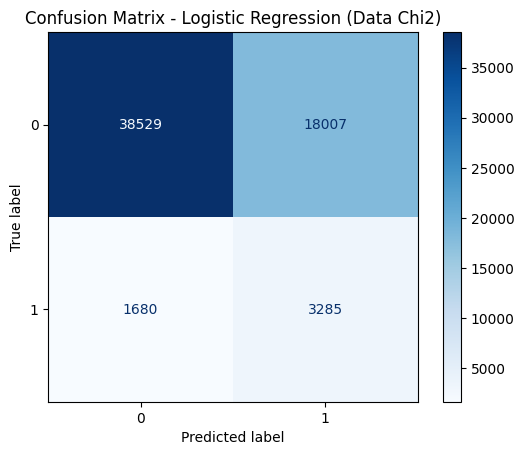

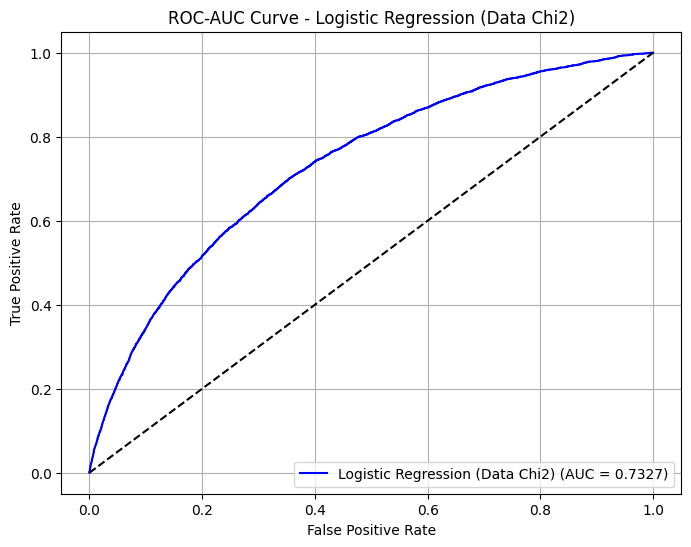

In [37]:
param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(log_reg_model, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
grid_lr_fitted = latih_dan_evaluasi_model(grid_lr, 
                                          X_train_upsampled_chi2, y_train_upsampled_chi2, 
                                          X_val_chi2, y_val, 
                                          model_name="Logistic Regression (Data Chi2)")

### LightGBM

Train and evaluate: LightGBM (Data MI)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Info] Number of positive: 226144, number of negative: 226144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1879
[LightGBM] [Info] Number of data points in the train set: 452288, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Execution time: 24.55132s

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 50}
Best ROC-AUC (CV): 0.7975

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.11      0.20     56536
           1       0.09      0.97      0.16      4965

    accuracy                           0.18     61501
   macro avg       0.

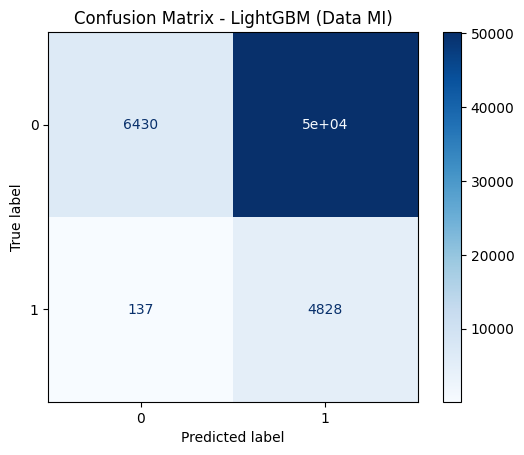

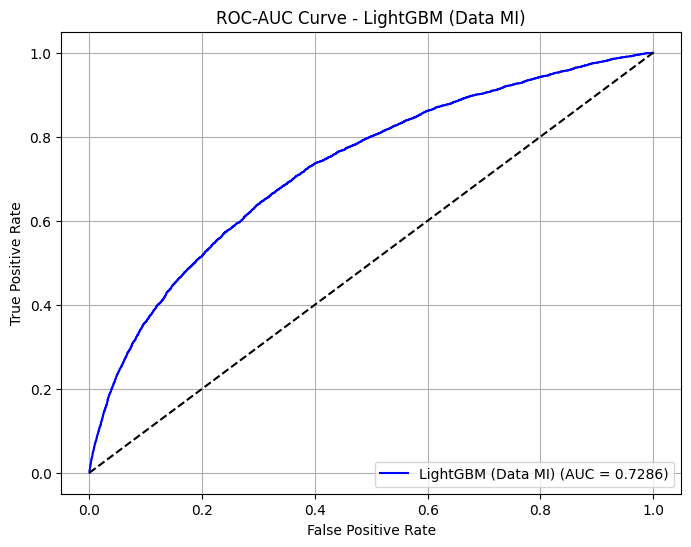

In [38]:
param_grid_lgbm = {
    'n_estimators': [100],                  
    'learning_rate': [0.1, 0.05],           
    'num_leaves': [31, 50],                 
}

grid_lgbm = GridSearchCV(lgbm_model, param_grid_lgbm, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
grid_lgbm_fitted = latih_dan_evaluasi_model(grid_lgbm, 
                                            X_train_upsampled_mi, y_train_upsampled_mi, 
                                            X_val_mi, y_val, 
                                            model_name="LightGBM (Data MI)")

### Random Forest

Train and evaluate: Random Forest (Data Chi2)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Execution time: 185.97942s

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Best ROC-AUC (CV): 0.9911

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     56536
           1       0.23      0.23      0.23      4965

    accuracy                           0.87     61501
   macro avg       0.58      0.58      0.58     61501
weighted avg       0.88      0.87      0.87     61501


ROC-AUC on Test Set:
0.7082

Confusion Matrix:


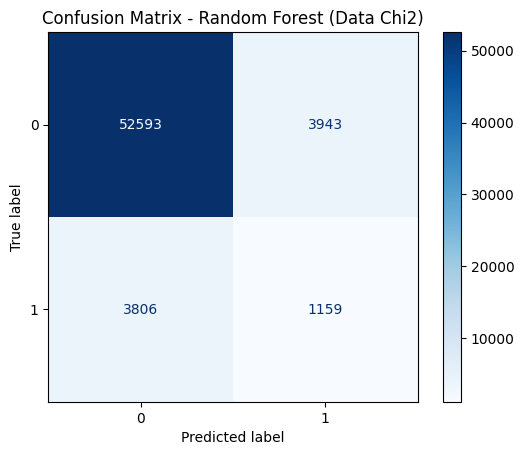

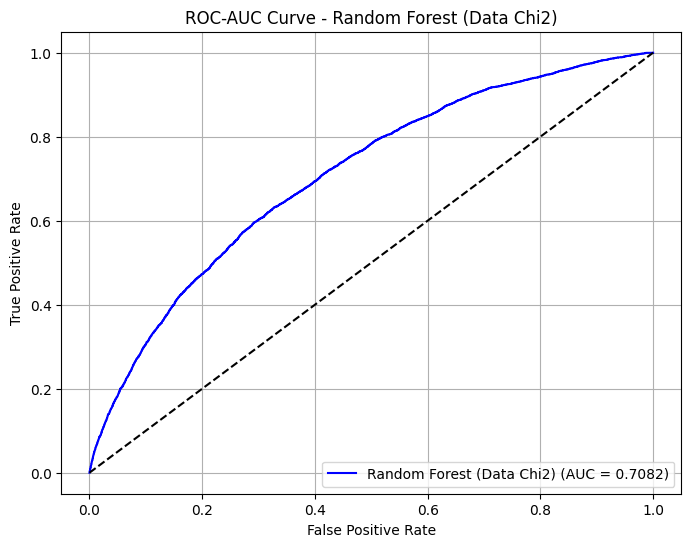

In [39]:
param_grid_rfc = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'max_features': ['sqrt']
}

grid_rfc = GridSearchCV(rfc_model, param_grid_rfc, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
grid_rfc_fitted = latih_dan_evaluasi_model(grid_rfc, 
                                           X_train_upsampled_chi2, y_train_upsampled_chi2, 
                                           X_val_chi2, y_val, 
                                           model_name="Random Forest (Data Chi2)")

# Prediction on Test Set ('application_test.csv')

In [44]:
app_test_chi2 = pd.read_csv(os.path.join(path, 'app_test_chi2.csv'))
app_test_id = pd.read_csv(os.path.join(path, 'app_test_id.csv'))

In [46]:
predict = pd.Series(grid_lgbm.predict(app_test_chi2), name = "TARGET").astype(int)
results = pd.concat([app_test_id, predict],axis = 1)
results.to_csv("predict_application.csv", index = False)
results.head()

,SK_ID_CURR,TARGET
0,100001,1
1,100005,0
2,100013,1
3,100028,1
4,100038,0
